## Basic Information

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
song_data = pd.read_csv("song_data_processed.csv")
features = song_data.columns.drop("song_popularity")
print(song_data.head(), features)

   song_popularity  song_duration_ms  acousticness  danceability  energy  \
0               73            262333      0.005520         0.496   0.682   
1               66            216933      0.010300         0.542   0.853   
2               76            231733      0.008170         0.737   0.463   
3               74            216933      0.026400         0.451   0.970   
4               56            223826      0.000954         0.447   0.766   

   instrumentalness  liveness  loudness  speechiness    tempo  ...  key_7  \
0          0.000029    0.0589    -4.095       0.0294  167.060  ...  False   
1          0.000000    0.1080    -6.407       0.0498  105.256  ...  False   
2          0.447000    0.2550    -7.828       0.0792  123.881  ...  False   
3          0.003550    0.1020    -4.938       0.1070  122.444  ...  False   
4          0.000000    0.1130    -5.065       0.0313  172.011  ...  False   

   key_8  key_9  key_10  key_11  audio_mode_1  time_signature_1  \
0   True  Fal

In [3]:
def preprocess_data(file_path):
    """
    Preprocess the song data from a CSV file.
    This function reads song data from a CSV file, removes duplicate rows,
    and drops the 'song_name' column. It then identifies the features to be
    plotted against 'song_popularity'.
    Parameters:
    file_path (str): The path to the CSV file containing the song data.
    Returns:
    tuple: A tuple containing:
        - song_data (DataFrame): The preprocessed song data.
        - features (Index): The features to plot against 'song_popularity'.
    """

    song_data = pd.read_csv(file_path)
    song_data = song_data.drop_duplicates().drop(columns=['song_name'])
    features = song_data.columns.drop('song_popularity')

    return song_data, features

song_data_raw, features_raw = preprocess_data("song_data.csv")

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

###  Correlation

First look at the correlation of each features to song popularity.

The result indicates that all features have only very weak correlation with song popularity, with at most $\approx 0.09$ in absolute value. This suggests that we might consider combination of several features to fit a better model.

Correlation of features with 'song_popularity':
 danceability        0.056415
loudness            0.052114
key_1               0.031264
time_signature_4    0.022226
key_6               0.020305
audio_mode_1        0.008824
key_11              0.008603
key_10              0.007812
time_signature_5    0.001493
key_5              -0.000070
speechiness        -0.001971
key_8              -0.002629
key_4              -0.007740
song_duration_ms   -0.007766
time_signature_1   -0.009507
key_3              -0.010737
key_2              -0.011771
key_9              -0.015307
key_7              -0.015710
energy             -0.016468
time_signature_3   -0.023153
tempo              -0.029560
acousticness       -0.031658
liveness           -0.038553
audio_valence      -0.043963
instrumentalness   -0.093032
Name: song_popularity, dtype: float64


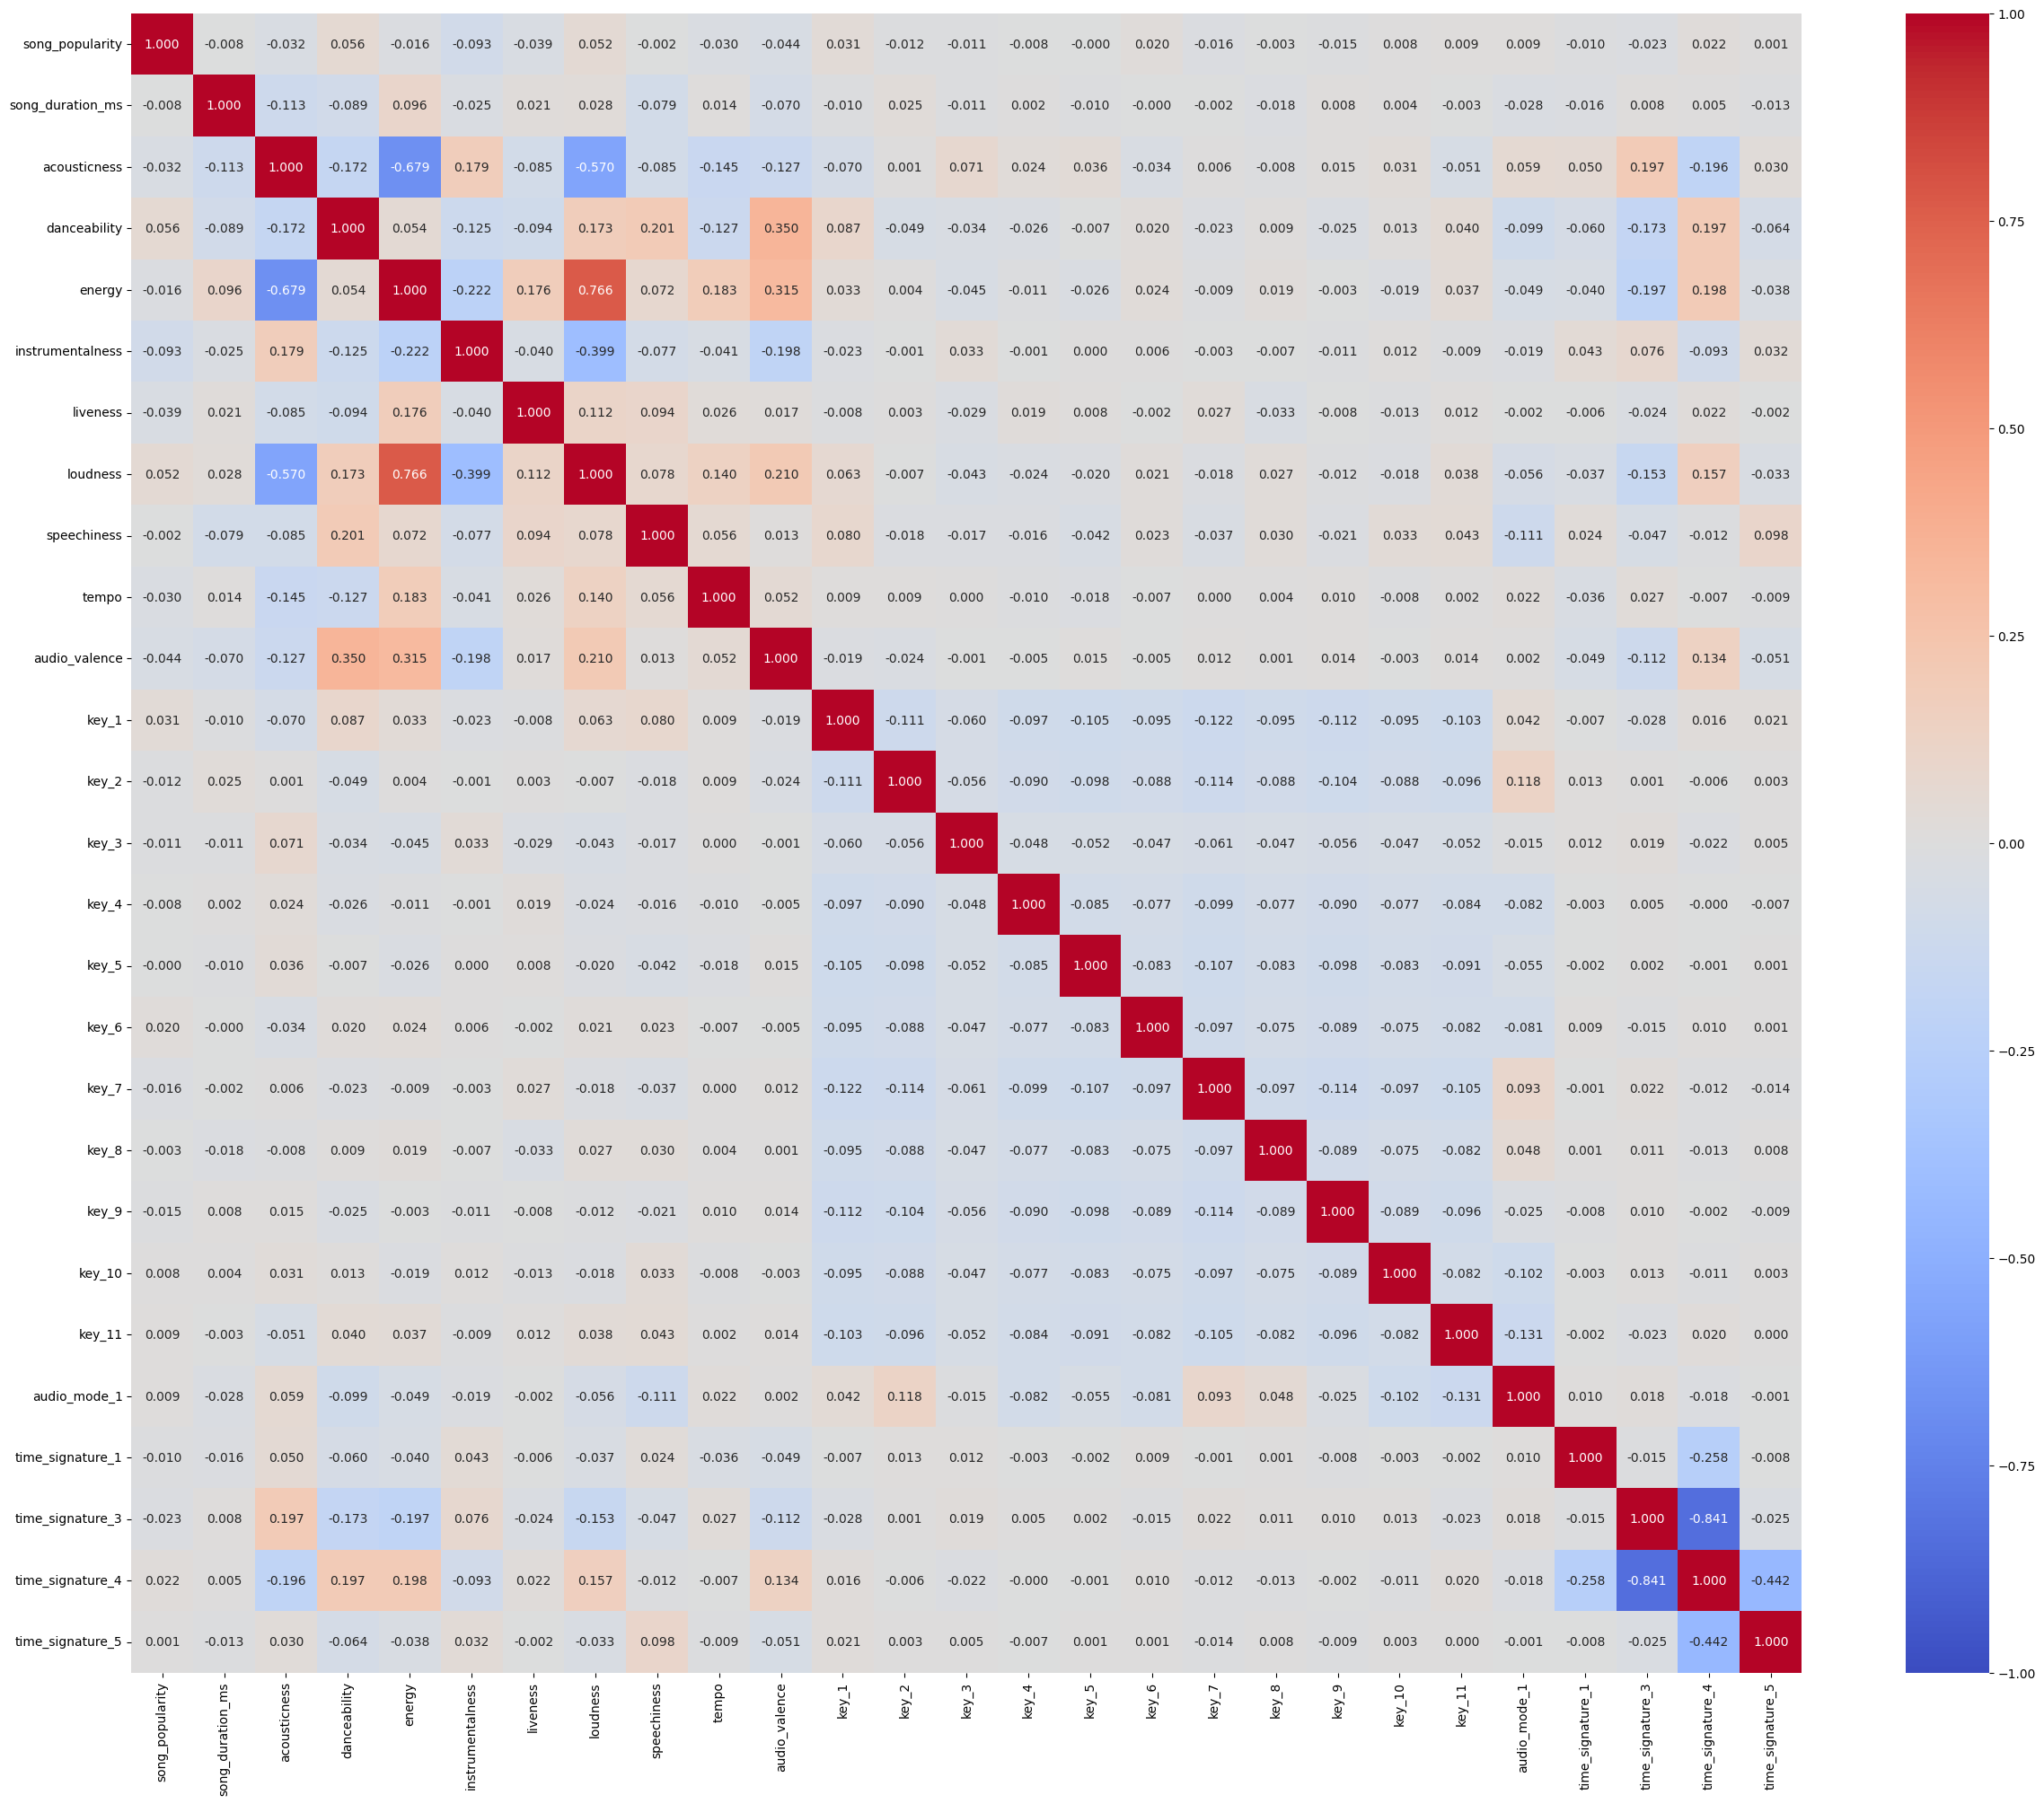

In [5]:
def compute_and_plot_correlations(data, target):
    """
    Compute and plot the correlation matrix with the target variable.
    
    Parameters:
    data (DataFrame): The dataset containing features and target variable.
    target (str): The target variable column name.
    
    Returns:
    None
    """
    # Compute correlation matrix with the target variable
    target_correlation = data.corr()[target].sort_values(ascending=False)

    # Display top correlated features
    print(f"Correlation of features with '{target}':\n", target_correlation.drop(target))

    # Plot heatmap for all features
    plt.figure(figsize=[30, 24])
    sns.heatmap(data.corr(), annot=True, vmax=1, vmin=-1, center=0, fmt=".3f", cmap="coolwarm")
    plt.show()

# Call the function with the song_data and 'song_popularity' as target
compute_and_plot_correlations(song_data, 'song_popularity')

## Data Splitting and Scaling

In [6]:
def split_and_scale_data(song_data, features, target='song_popularity', test_size=0.2, random_state=1):
    """
    Splits the data into training and testing sets and scales the features.
    
    Parameters:
    song_data (DataFrame): The dataset containing features and target variable.
    features (list): List of feature column names.
    target (str): The target variable column name. Default is 'song_popularity'.
    test_size (float): The proportion of the dataset to include in the test split. Default is 0.2.
    random_state (int): Random seed for reproducibility. Default is 1.
    
    Returns:
    tuple: Scaled training and testing features, and training and testing target variables.
    """
    
    # Splitting the data
    X = song_data[features]
    y = song_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [7]:

X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale_data(song_data, features, random_state=2024)
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_scaled shape: (11940, 26)
X_test_scaled shape: (2986, 26)
y_train shape: (11940,)
y_test shape: (2986,)


## Machine Learning Models

In [8]:
def evaluate_model(y_test, y_pred, model_name):
    """
    Evaluate the performance of a regression model using various metrics.
    Parameters:
    y_test (array-like): True values of the target variable.
    y_pred (array-like): Predicted values of the target variable.
    model_name (str): Name of the model being evaluated.
    Returns:
    tuple: A tuple containing the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), 
           and R-squared value (R^2) of the model.
    """

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared Value (R^2): {r2:.2f}")
    print("\n")
    
    return mse, rmse, r2

In [9]:
def plot_hyperparameter_tuning_results(grid_search, title):
    """
    Visualize hyperparameter tuning results from a GridSearchCV object.
    Parameters:
    grid_search (GridSearchCV): The GridSearchCV object containing the results of the hyperparameter tuning.
    title (str): The title for the plot.
    Returns:
    None: This function does not return any value. It displays a plot of the hyperparameter tuning results.
    """

    # Visualize hyperparameter tuning results
    plt.figure(figsize=(8, 6))
    alphas = grid_search.cv_results_['param_alpha'].data.astype(float)
    mean_test_scores = -grid_search.cv_results_['mean_test_score']  # Convert negative MSE back to positive
    plt.plot(alphas, mean_test_scores, marker='o', label='Validation MSE', color='purple', markersize=4.5)
    plt.xscale('log')
    plt.xlabel("Alpha")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(f"Hyperparameter Tuning: {title}")
    plt.legend()
    plt.grid(axis='y')
    plt.show()

In [10]:
def plot_model_results(y_test, y_pred, model, title):
    """
    Plots the results of a regression model including actual vs predicted values, residuals, and feature coefficients.
    Parameters:
    y_test (array-like): Actual values of the target variable.
    y_pred (array-like): Predicted values of the target variable by the model.
    model (object): Trained regression model with a `coef_` attribute.
    title (str): Title for the plots.
    Returns:
    None. This function does not return any value. It displays two plots. The first one is the plot for actual vs predicted values, and the second one for residuals vs predicted values.
    """

    # Plot actual vs predicted values of song popularity
    plt.figure(figsize=(6, 4.5))
    plt.scatter(y_test, y_pred, alpha=0.5, s=10)
    # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="y_test = y_pred")
    plt.xlabel("Actual Song Popularity")
    plt.ylabel("Predicted Song Popularity")
    plt.title(f"{title}: Actual vs Predicted Song Popularity")
    # plt.grid(True)
    # plt.legend()
    plt.show()

    # Plot residuals against predicted song popularity
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4.5))
    plt.scatter(y_pred, residuals, alpha=0.5, s=10)
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Residue')
    plt.xlabel("Predicted Song Popularity")
    plt.ylabel("Residuals")
    plt.title(f"{title}: Residuals vs Predicted Song Popularity")
    # plt.grid(True)
    plt.legend()
    plt.show()

def plot_parameter_values(model, features, title):
    """
    Plots the parameter values (coefficients) of a given model.
    Parameters:
    model (object): The trained model with a `coef_` attribute.
    features (list of str): The list of feature names corresponding to the coefficients.
    title (str): The title for the plot.
    Returns:
    None
    """


    # Plot parameter values (coefficients)
    coefficients = model.coef_

    plt.figure(figsize=(10, 8))
    plt.barh(features, coefficients, color='teal')
    plt.axvline(x=0, color='r', linestyle='--')  # Line at zero
    plt.xlabel("Values of Coefficients")
    plt.ylabel("Features")
    plt.title(f"{title}: Feature Coefficients")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.grid(axis='x')
    plt.show()

### Linear Regression

In [11]:
def train_linear_regression(X_train_scaled, y_train):
    """
    Train a Linear Regression model on the given training data.
    
    Parameters:
    X_train_scaled (array-like): Scaled training features.
    y_train (array-like): Training target variable.
    
    Returns:
    model: Trained Linear Regression model.
    """
    # Initialize Linear Regression model
    model = LinearRegression()

    # Fit the model on training set
    model.fit(X_train_scaled, y_train)
    
    return model



In [12]:


def evaluate_linear_regression(model, X_test_scaled, y_test, features):
    """
    Evaluate a Linear Regression model.
    
    Parameters:
    model: Trained Linear Regression model.
    X_test_scaled (array-like): Scaled testing features.
    y_test (array-like): Testing target variable.
    features (list): List of feature names.
    
    Returns:
    tuple: A tuple containing the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), 
           and R-squared value (R^2) of the model.
    """
    # Make predictions on test data
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse_lr, rmse_lr, r2_lr = evaluate_model(y_test, y_pred, "Linear Regression")
    print(f"Intercept Value: {model.intercept_:.2f}")

    plot_model_results(y_test, y_pred, model, "Linear Regression")
    plot_parameter_values(model, features, "Linear Regression")
    
    return mse_lr, rmse_lr, r2_lr


Linear Regression Evaluation Metrics:
Mean Squared Error (MSE): 415.65
Root Mean Squared Error (RMSE): 20.39
R-squared Value (R^2): 0.02


Intercept Value: 48.85


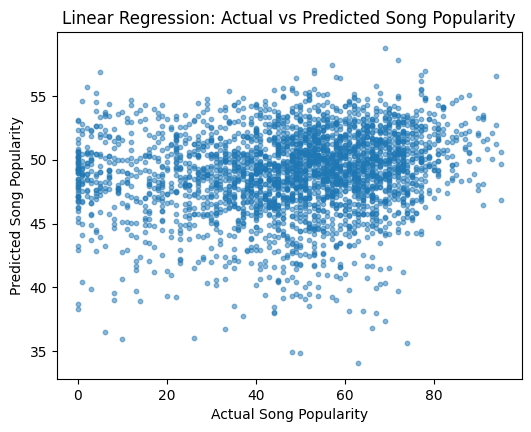

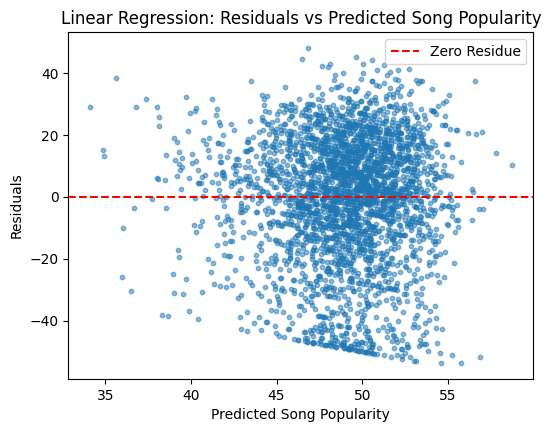

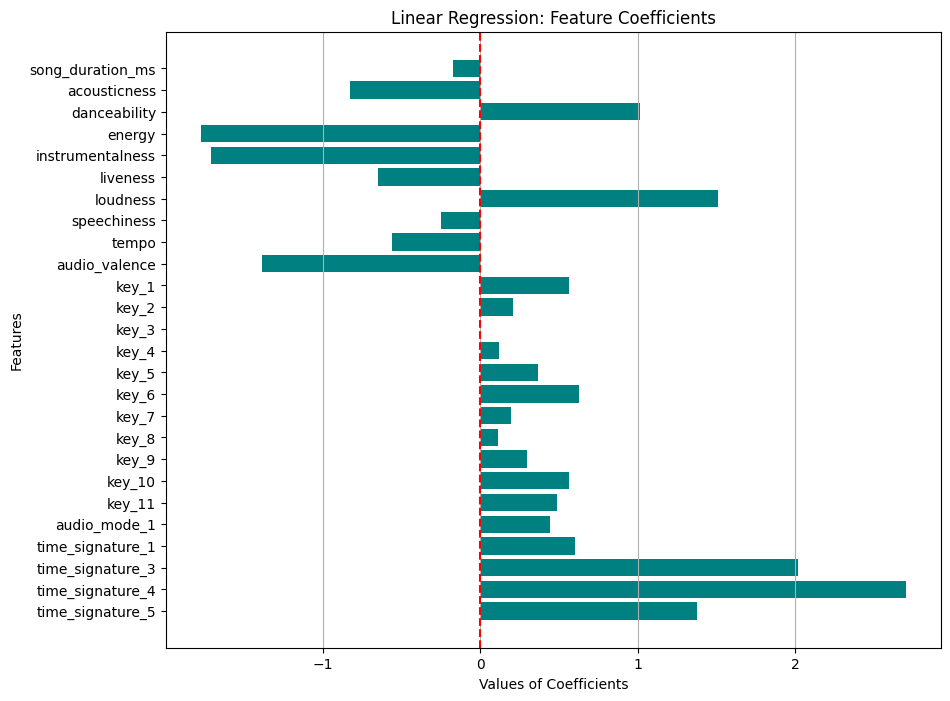

In [13]:
# Train the Linear Regression model
linear_regression_model = train_linear_regression(X_train_scaled, y_train)

# Evaluate the Linear Regression model
mse_lr, rmse_lr, r2_lr = evaluate_linear_regression(linear_regression_model, X_test_scaled, y_test, features)

### Ridge Regression

Here we minimize the function $||y - Xw||^2_2 + \alpha ||w||^2_2$, where $\alpha$ is a hyperparameter we need to tune by searching from $10^{-2} = 0.01$ to $10^{3.3} \approx 2000$ in log scale.

To find the best hyperparameter, we use $5$-fold cross validation.

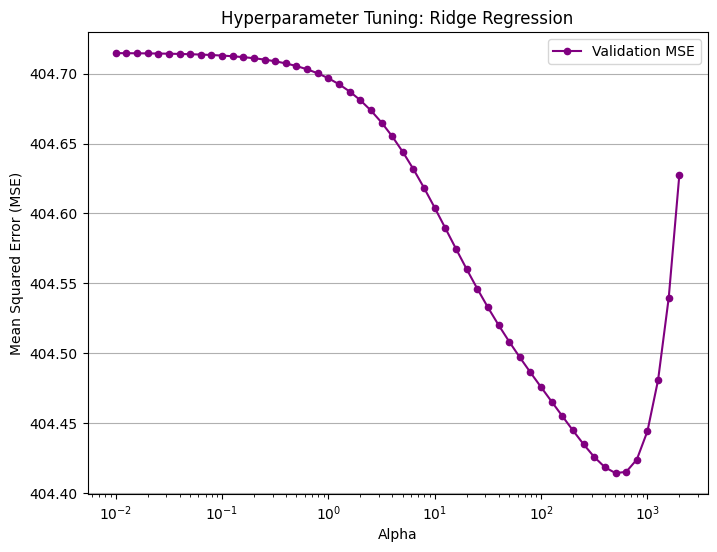

Best alpha: 501.1872
Best cross-validated score (negative of MSE): -404.41
Ridge Regression Evaluation Metrics:
Mean Squared Error (MSE): 415.63
Root Mean Squared Error (RMSE): 20.39
R-squared Value (R^2): 0.02


Incercept Value: 48.85


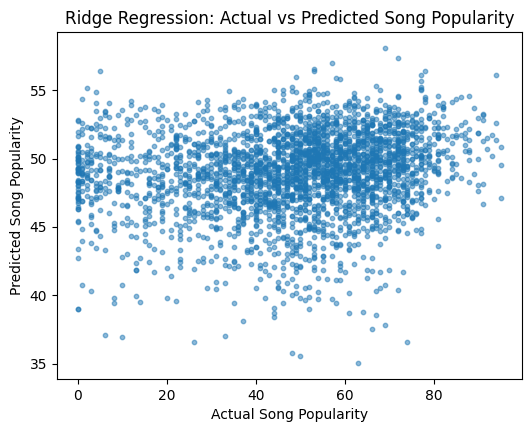

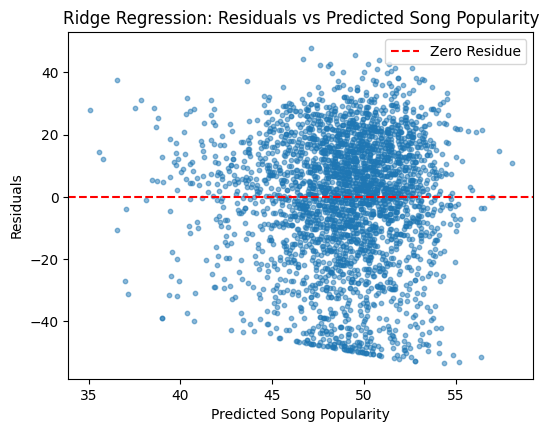

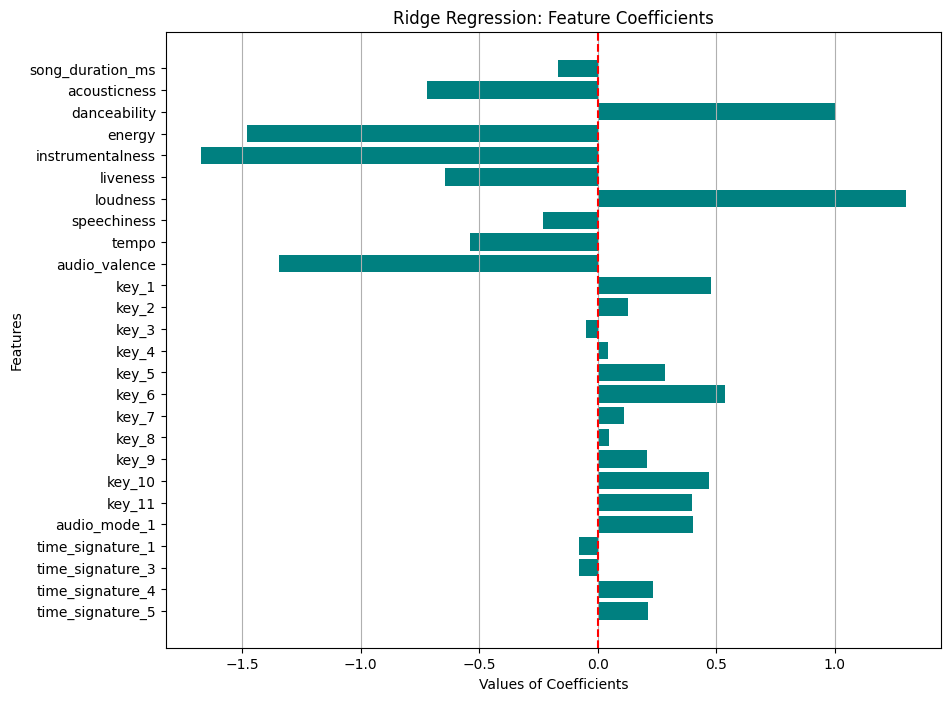

In [14]:
def train_ridge_regression(X_train_scaled, y_train):
    """
    Trains a Ridge Regression model using cross-validated grid search to find the best hyperparameter (alpha).
    Parameters:
    X_train_scaled (numpy.ndarray or pandas.DataFrame): The scaled training data features.
    y_train (numpy.ndarray or pandas.Series): The training data target values.
    Returns:
    Ridge: The Ridge Regression model with the best found hyperparameter.
    The function performs the following steps:
    1. Defines a Ridge Regression model and a range of alpha values for hyperparameter tuning.
    2. Uses GridSearchCV to find the best alpha value based on cross-validated negative mean squared error.
    3. Visualizes the hyperparameter tuning results.
    4. Prints the best alpha value and the best cross-validated score.
    5. Returns the Ridge Regression model with the best found alpha value.
    """
    
    # Define Ridge Regression model and the range of hyperparameters (alpha values)
    ridge = Ridge()
    param_grid = {'alpha': np.logspace(-2, 3.3, 54)}  # alpha values from 0.01 to 10^3.3 \approx 2000

    # Find the best hyperparameter
    grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_scaled, y_train)

    # Visualize hyperparameter tuning results
    plot_hyperparameter_tuning_results(grid_search, "Ridge Regression")

    # Get the best model through hyperparameter
    ridge_est = grid_search.best_estimator_
    alpha_est = grid_search.best_params_['alpha']

    print(f"Best alpha: {alpha_est:.4f}")
    print(f"Best cross-validated score (negative of MSE): {grid_search.best_score_:.2f}")

    return ridge_est

def evaluate_ridge_regression(model, X_test_scaled, y_test, features):
    """
    Evaluate a Ridge Regression model.
    
    Parameters:
    model: Trained Ridge Regression model.
    X_test_scaled (array-like): Scaled testing features.
    y_test (array-like): Testing target variable.
    features (list): List of feature names.
    
    Returns:
    tuple: A tuple containing the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), 
           and R-squared value (R^2) of the model.
    """
    # Evaluate the model on the test data
    y_pred_ridge = model.predict(X_test_scaled)
    mse_ridge, rmse_ridge, r2_ridge = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
    print(f"Incercept Value: {model.intercept_:.2f}")

    # Plot actual vs predicted values of song popularity
    plot_model_results(y_test, y_pred_ridge, model, "Ridge Regression")

    # Plot parameter values (coefficients) of Ridge Regression
    plot_parameter_values(model, features, "Ridge Regression")
    
    return mse_ridge, rmse_ridge, r2_ridge

# Train the Ridge Regression model
ridge_est = train_ridge_regression(X_train_scaled, y_train)
# Evaluate the Ridge Regression model
mse_ridge, rmse_ridge, r2_ridge = evaluate_ridge_regression(ridge_est, X_test_scaled, y_test, features)

We can see through the result below that the best hyperparameter is $\hat{\alpha} \approx 500$. Though the small $R^2$ indicate that the fitting is ineffective.

### LASSO Regression

Here we minimize the function $\frac{1}{2N} ||y - Xw||^2_2 + \alpha * ||w||_1$, where $N$ is the number of smaples, and $\alpha$ is a hyperparameter we need to tune by searching from $10^{-4}$ to $10$ in log scale. Note that the scale of $\alpha$ could be different with that in Ridge Regression.

To find the best hyperparameter, we use $5$-fold cross validation.

In [15]:
def train_lasso_regression(X_train_scaled, y_train):
    """
    Train a Lasso Regression model using cross-validated grid search to find the best hyperparameter (alpha).
    
    Parameters:
    X_train_scaled (numpy.ndarray or pandas.DataFrame): The scaled training data features.
    y_train (numpy.ndarray or pandas.Series): The training data target values.
    
    Returns:
    Lasso: The Lasso Regression model with the best found hyperparameter.
    """
    # Define the Lasso Regression model and the range of hyperparameters (alpha values) for tuning
    lasso = Lasso(max_iter=10000)
    param_grid = {'alpha': np.logspace(-4, 1, 51)}  # alpha values from 0.0001 to 10

    # Find the best hyperparameter for LASSO
    grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_scaled, y_train)

    # Visualize hyperparameter tuning results
    plot_hyperparameter_tuning_results(grid_search, "LASSO Regression")

    # Get the best LASSO model and hyperparameter
    lasso_est = grid_search.best_estimator_
    alpha_est = grid_search.best_params_['alpha']

    print(f"Best alpha: {alpha_est:.4f}")
    print(f"Best cross-validated score (negative MSE): {grid_search.best_score_:.2f}")

    return lasso_est

In [16]:
def evaluate_lasso_regression(model, X_test_scaled, y_test, features):
    """
    Evaluate a Lasso Regression model.
    
    Parameters:
    model: Trained Lasso Regression model.
    X_test_scaled (array-like): Scaled testing features.
    y_test (array-like): Testing target variable.
    features (list): List of feature names.
    
    Returns:
    tuple: A tuple containing the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), 
           and R-squared value (R^2) of the model.
    """
    # Evaluate the model on the test data
    y_pred_lasso = model.predict(X_test_scaled)
    mse_lasso, rmse_lasso, r2_lasso = evaluate_model(y_test, y_pred_lasso, "LASSO Regression")
    print(f"Intercept Value: {model.intercept_:.2f}")

    # Plot actual vs predicted values of song popularity
    plot_model_results(y_test, y_pred_lasso, model, "LASSO Regression")

    # Plot parameter values (coefficients) of LASSO Regression
    plot_parameter_values(model, features, "LASSO Regression")
    
    return mse_lasso, rmse_lasso, r2_lasso



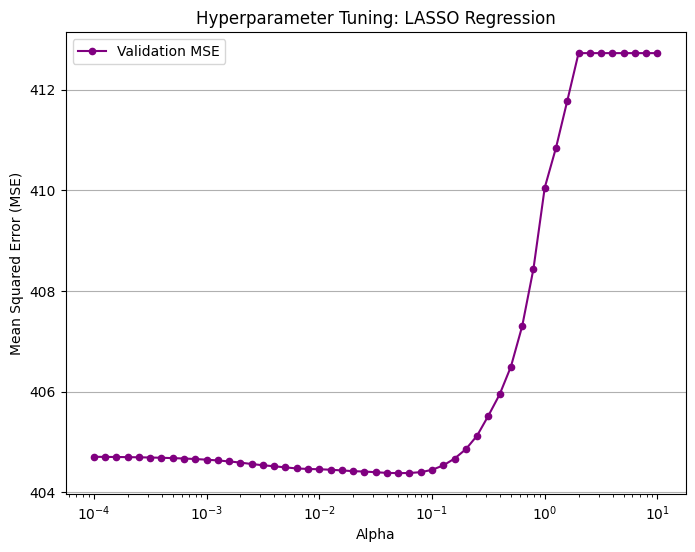

Best alpha: 0.0501
Best cross-validated score (negative MSE): -404.38
LASSO Regression Evaluation Metrics:
Mean Squared Error (MSE): 415.08
Root Mean Squared Error (RMSE): 20.37
R-squared Value (R^2): 0.02


Intercept Value: 48.85


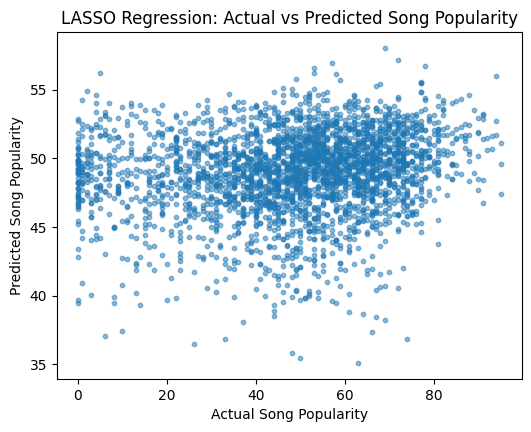

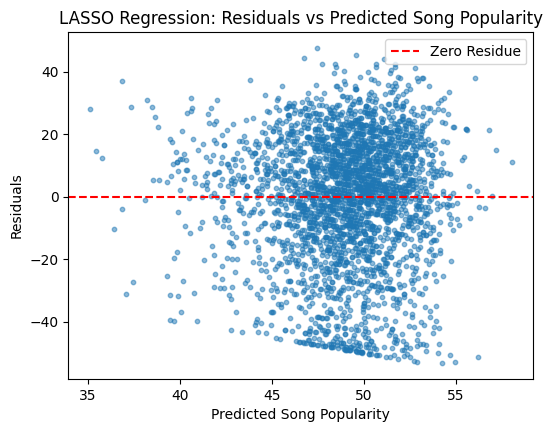

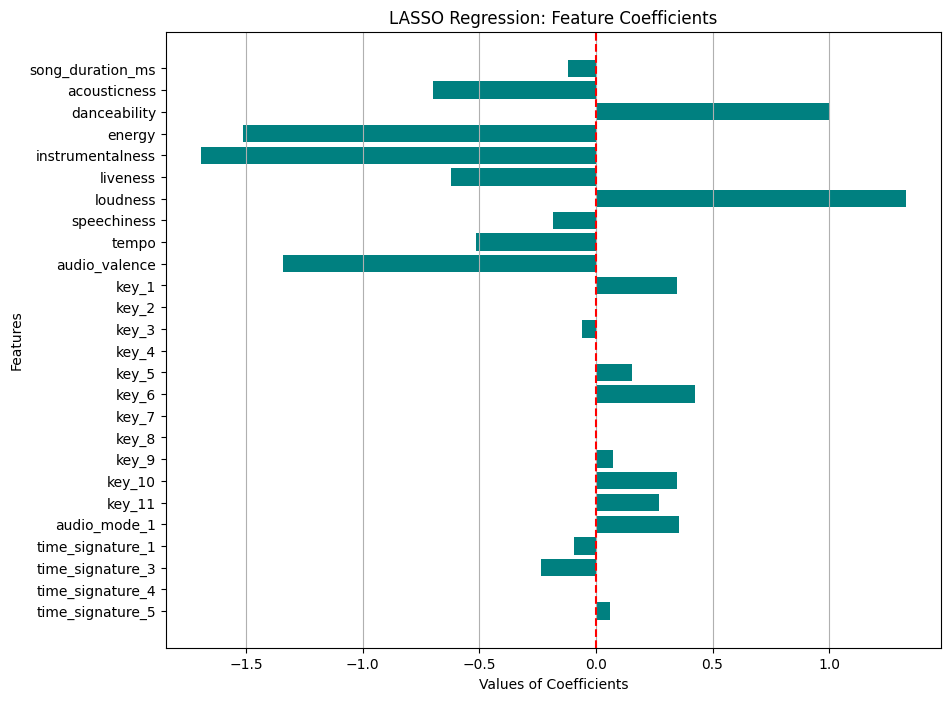

In [17]:
# Train the Lasso Regression model
lasso_est = train_lasso_regression(X_train_scaled, y_train)

# Evaluate the Lasso Regression model
mse_lasso, rmse_lasso, r2_lasso = evaluate_lasso_regression(lasso_est, X_test_scaled, y_test, features)

We can see through the result below that the best hyperparameter is $\hat{\alpha} \approx 0.05$. Though the small $R^2$ indicate that the fitting is ineffective.

## Random Forest Regression

In [18]:
def plot_feature_importance(model, features):
    """
    Plot the feature importances for a given model.
    
    Parameters:
    model: Trained model with feature_importances_ attribute.
    features (list or array-like): List of feature names.
    
    Returns:
    None
    """
    importances = model.feature_importances_
    plt.figure(figsize=(10, 8))
    plt.barh(np.array(features), importances, color="teal")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Random Forest: Feature Importances")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.grid(axis='x')
    plt.show()

In [ ]:
def train_random_forest(X_train_scaled, y_train):
    """
    Train a Random Forest Regression model using cross-validated grid search to find the best hyperparameters.
    
    Parameters:
    X_train_scaled (numpy.ndarray or pandas.DataFrame): The scaled training data features.
    y_train (numpy.ndarray or pandas.Series): The training data target values.
    
    Returns:
    RandomForestRegressor: The Random Forest Regression model with the best found hyperparameters.
    """
    # Define the Random Forest Regression model
    rf = RandomForestRegressor(random_state=4202)

    # Define a range of hyperparameters for tuning
    param_grid = {
        'n_estimators': [50, 100, 200],       # Number of trees
        'max_depth': [None, 10, 20],          # Maximum depth of trees
        'min_samples_split': [2, 5],          # Minimum samples to split a node
        'min_samples_leaf': [1, 2, 4]         # Minimum samples per leaf node
    }

    # param_grid_tmp_test = {
    #     'n_estimators': [200],       # Number of trees
    #     'max_depth': [10],          # Maximum depth of trees
    #     'min_samples_split': [2],          # Minimum samples to split a node
    #     'min_samples_leaf': [2]         # Minimum samples per leaf node
    # }

    # Hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best model and hyperparameters
    rf_est = grid_search.best_estimator_

    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Best cross-validated score (negative MSE): {grid_search.best_score_:.2f}")

    return rf_est

In [20]:
def evaluate_random_forest(model, X_test_scaled, y_test, features):
    """
    Evaluate a Random Forest Regression model.
    
    Parameters:
    model: Trained Random Forest Regression model.
    X_test_scaled (array-like): Scaled testing features.
    y_test (array-like): Testing target variable.
    features (list): List of feature names.
    
    Returns:
    tuple: A tuple containing the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), 
           and R-squared value (R^2) of the model.
    """
    # Evaluate the model on the test data
    y_pred_rf = model.predict(X_test_scaled)
    mse_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest Regression")

    # Plot actual vs predicted values and Residuals
    plot_model_results(y_test, y_pred_rf, model, "Random Forest")

    # Plot feature importance
    plot_feature_importance(model, features)
    
    return mse_rf, rmse_rf, r2_rf

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.0s
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated score (negative MSE): -389.38
Random Forest Regression Evaluation Metrics:
Mean Squared Error (MSE): 400.62
Root Mean Squared Error (RMSE): 20.02
R-squared Value (R^2): 0.06




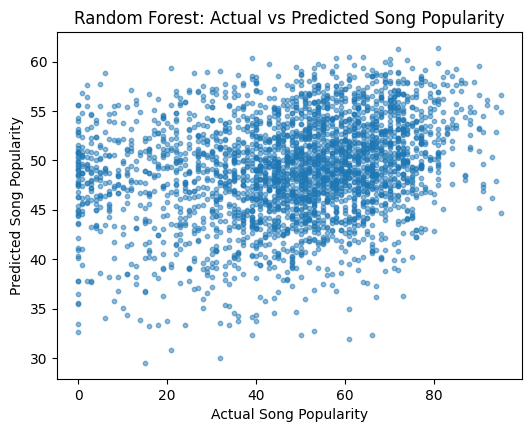

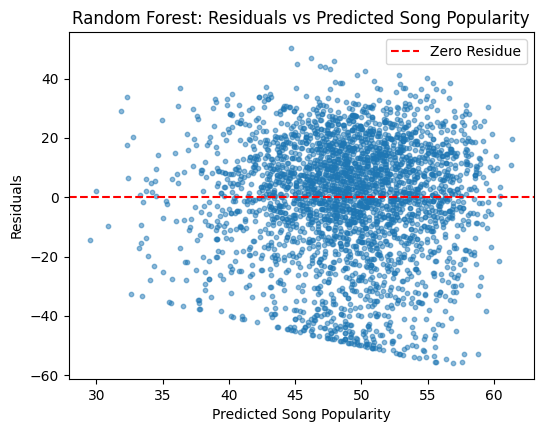

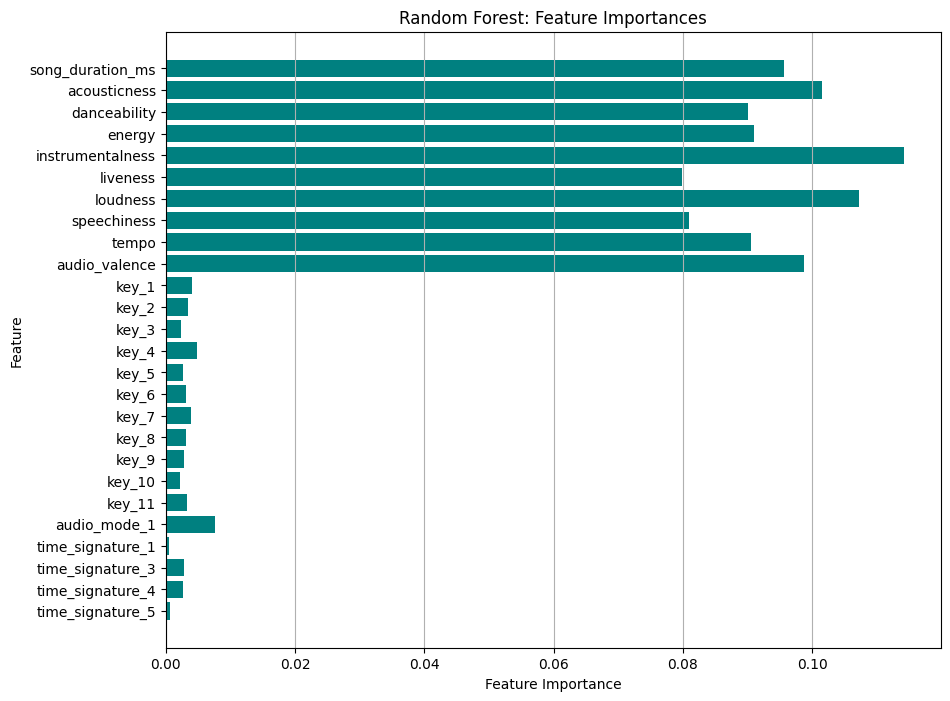

In [21]:
# Train the Random Forest model
rf_est = train_random_forest(X_train_scaled, y_train)

# Evaluate the Random Forest model
mse_rf, rmse_rf, r2_rf = evaluate_random_forest(rf_est, X_test_scaled, y_test, features)

We can see that there are boosts in performance for the nonlinear random forest regression model, but the prediction power is still limited.

### Neural Network

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [23]:
def preprocess_data(X_train_scaled, y_train, X_test_scaled, y_test):
    """
    Preprocesses the input data by converting it to PyTorch tensors and creating a DataLoader for batching.
    Args:
        X_train_scaled (numpy.ndarray or pandas.DataFrame): Scaled training features.
        y_train (pandas.Series or numpy.ndarray): Training labels.
        X_test_scaled (numpy.ndarray or pandas.DataFrame): Scaled test features.
        y_test (pandas.Series or numpy.ndarray): Test labels.
    Returns:
        tuple: A tuple containing:
            - X_train_tensor (torch.Tensor): Training features as a PyTorch tensor.
            - y_train_tensor (torch.Tensor): Training labels as a PyTorch tensor.
            - X_test_tensor (torch.Tensor): Test features as a PyTorch tensor.
            - y_test_tensor (torch.Tensor): Test labels as a PyTorch tensor.
    """
    # Set random seed for reproducibility
    torch.manual_seed(0)
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

# Preprocess the data
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = preprocess_data(X_train_scaled, y_train, X_test_scaled, y_test)

In [24]:
# Define of the Neural Network
class NeuralNet(nn.Module):
    """
    A simple feedforward neural network with one hidden layer.
    Attributes:
    -----------
    fc1 : nn.Linear
        The first fully connected layer.
    relu : nn.ReLU
        The ReLU activation function.
    fc2 : nn.Linear
        The second fully connected layer.
    fc3 : nn.Linear
        The third fully connected layer.
    Methods:
    --------
    __init__(input_size):
        Initializes the neural network with the given input size.
    forward(x):
        Defines the forward pass of the neural network.
    """
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
def train_neural_network(model, criterion, optimizer, X_train_tensor, y_train_tensor,X_test_tensor, y_test_tensor, epochs=1500):
    """
    Trains a neural network model and evaluates it on a test set.
    Args:
        model (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
        X_train_tensor (torch.Tensor): Tensor containing the training input data.
        y_train_tensor (torch.Tensor): Tensor containing the training target data.
        X_test_tensor (torch.Tensor): Tensor containing the test input data.
        y_test_tensor (torch.Tensor): Tensor containing the test target data.
        epochs (int, optional): Number of epochs to train the model. Default is 1500.
    Returns:
        tuple: A tuple containing two lists:
            - train_losses (list): List of training losses recorded at each epoch.
            - test_losses (list): List of test losses recorded at each epoch.
    """
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        train_loss = criterion(y_pred, y_train_tensor)
        train_loss.backward()
        optimizer.step()
        
        # Evaluation phase
        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test_tensor)
            test_loss = criterion(y_test_pred, y_test_tensor)
        
        # Record losses
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        
        # Print progress
        if (epoch + 1) % 250 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    
    return train_losses, test_losses

In [26]:
def plot_loss_over_epochs(train_losses, test_losses, epochs):
    """
    Plot the training and testing loss over epochs.
    
    Parameters:
    train_losses (list): List of training losses recorded over epochs.
    test_losses (list): List of testing losses recorded over epochs.
    epochs (int): Number of epochs.
    
    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss over Epochs in Neural Network Training')
    plt.legend()
    plt.show()

Epoch 250/1500, Train Loss: 422.1841, Test Loss: 442.2596
Epoch 500/1500, Train Loss: 397.1366, Test Loss: 420.9473
Epoch 750/1500, Train Loss: 388.6364, Test Loss: 417.0964
Epoch 1000/1500, Train Loss: 383.8592, Test Loss: 417.1184
Epoch 1250/1500, Train Loss: 379.3907, Test Loss: 417.7202
Epoch 1500/1500, Train Loss: 374.1378, Test Loss: 419.3423


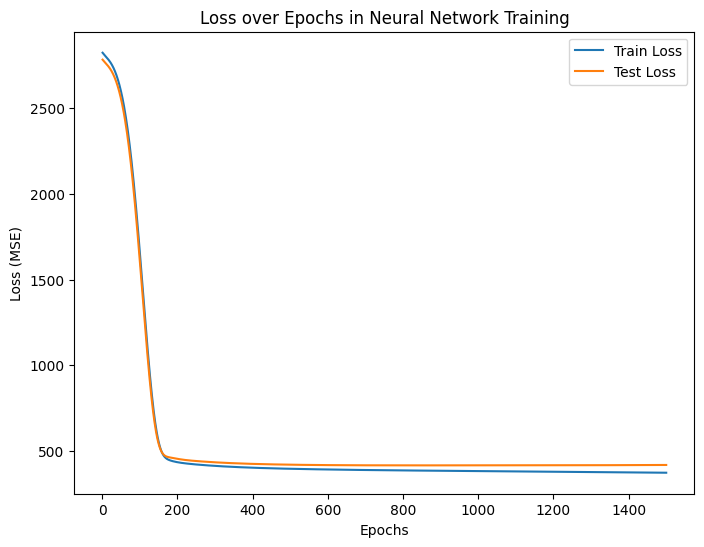

In [27]:
# Initialize the neural network model
nn_model = NeuralNet(X_train_tensor.shape[1])

# Train the neural network
train_losses, test_losses = train_neural_network(nn_model, nn.MSELoss(), optim.Adam(nn_model.parameters(), lr=0.001), X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=1500)

# Plot the loss over epochs
plot_loss_over_epochs(train_losses, test_losses, epochs=1500)

In [28]:
def evaluate_neural_network(model, X_test_tensor, y_test):
    """
    Evaluate the neural network model on the test set.
    
    Parameters:
    model (torch.nn.Module): Trained neural network model.
    X_test_tensor (torch.Tensor): Test features as a PyTorch tensor.
    y_test_tensor (torch.Tensor): Test target values as a PyTorch tensor.
    
    Returns:
    tuple: A tuple containing the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), 
           and R-squared value (R^2) of the model.
    """
    model.eval()
    with torch.no_grad():
        y_pred_nn = model(X_test_tensor).numpy()
    
    mse_nn, rmse_nn, r2_nn = evaluate_model(y_test, y_pred_nn, "Neural Network")
    
    return mse_nn, rmse_nn, r2_nn, y_pred_nn

In [29]:
def plot_neural_network_results(y_test, y_pred_nn):
    """
    Plot the results of the neural network model including actual vs predicted values and residuals.
    
    Parameters:
    y_test (array-like): Actual values of the target variable.
    y_pred_nn (array-like): Predicted values of the target variable by the neural network model.
    
    Returns:
    None
    """
    # Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_nn, alpha=0.5, s=8, label="Predicted vs Actual Song Popularity")
    plt.xlabel("Actual Song Popularity")
    plt.ylabel("Predicted Song Popularity")
    plt.title("Neural Network: Actual vs Predicted Song Popularity")
    plt.legend()
    plt.show()

    # Residual Plot
    residuals_nn = y_test - y_pred_nn.flatten()
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred_nn, residuals_nn, alpha=0.5, s=8)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Song Popularity")
    plt.ylabel("Residuals")
    plt.title("Neural Network: Residuals vs Predicted Song Popularity")
    plt.show()

Neural Network Evaluation Metrics:
Mean Squared Error (MSE): 419.34
Root Mean Squared Error (RMSE): 20.48
R-squared Value (R^2): 0.01




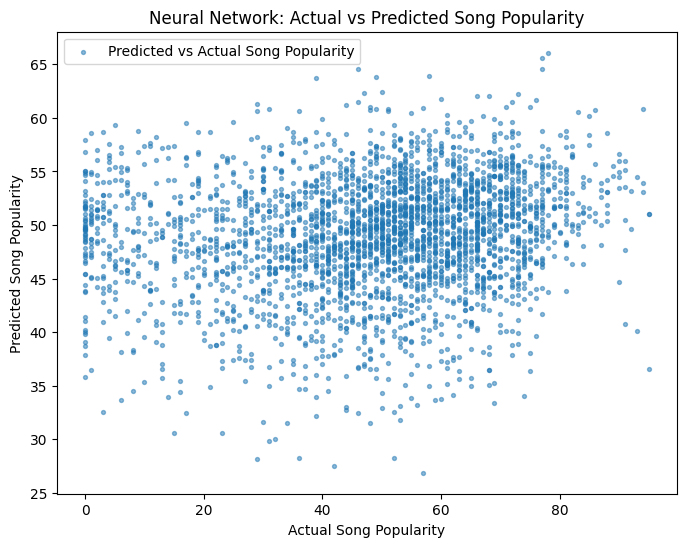

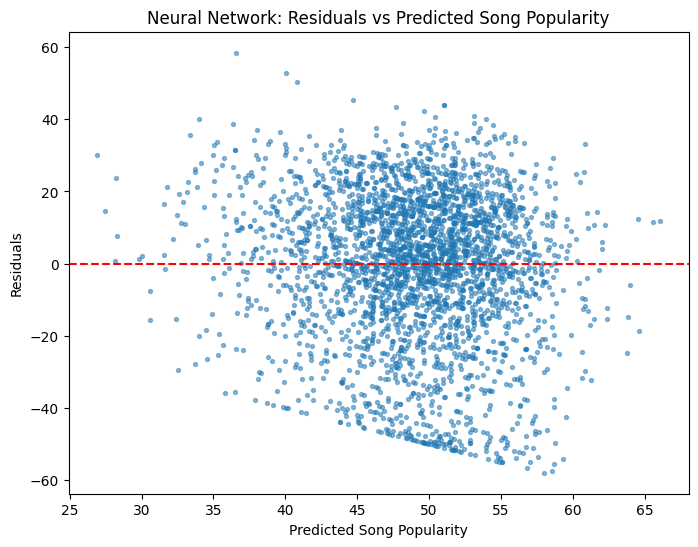

In [30]:
# Evaluate the neural network model
mse_nn, rmse_nn, r2_nn, y_pred_nn = evaluate_neural_network(nn_model, X_test_tensor, y_test)

# Plot the neural network results
plot_neural_network_results(y_test, y_pred_nn)

## Model Selection

### Plotting metrics

In [31]:
# Define model metrics
model_metrics = {
    "Model": ["Linear Reg.", "Ridge Reg.", "LASSO", "Random Forest", "Neural Net"],
    "MSE": [mse_lr, mse_ridge, mse_lasso, mse_rf, mse_nn],
    "RMSE": [rmse_lr, rmse_ridge, rmse_lasso, rmse_rf, rmse_nn],
    "R^2": [r2_lr, r2_ridge, r2_lasso, r2_rf, r2_nn]
}

# Convert to a DataFrame for better visualization
metrics_df = pd.DataFrame(model_metrics)

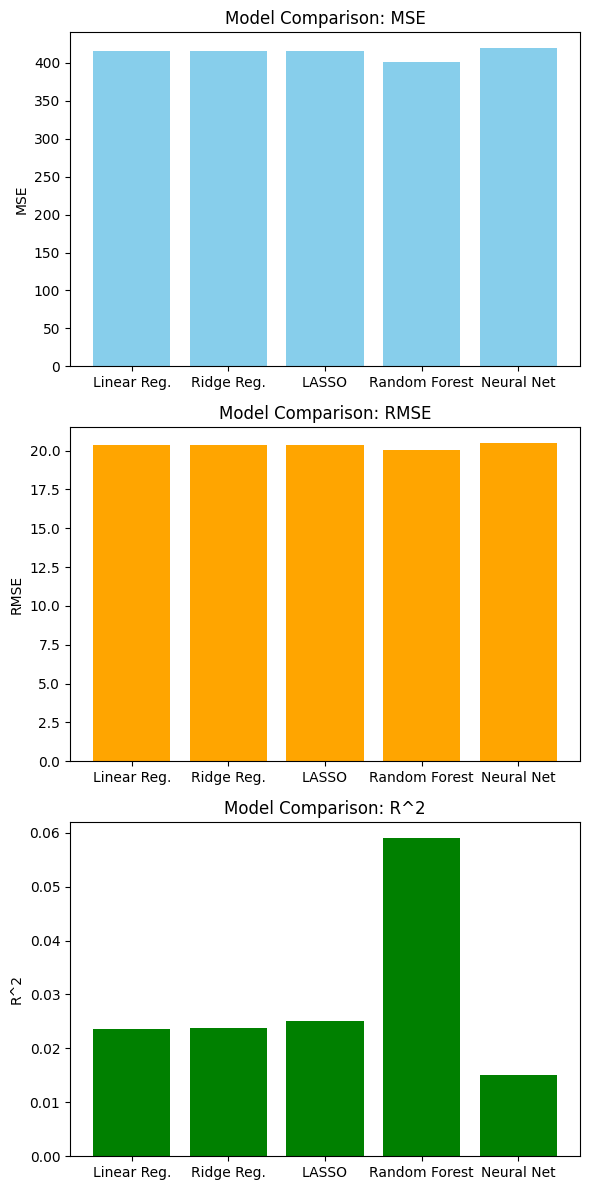

In [32]:
def plot_metrics(metrics_df):
    """
    Plot the model metrics from a DataFrame.
    
    Parameters:
    metrics_df (DataFrame): DataFrame containing the model metrics.
    
    Returns:
    None
    """
    fig, axes = plt.subplots(3, 1, figsize=(6, 12))

    metrics = ["MSE", "RMSE", "R^2"]
    colors = ["skyblue", "orange", "green"]
    titles = ["Model Comparison: MSE", "Model Comparison: RMSE", "Model Comparison: R^2"]
    # y_labels = ["MSE", "RMSE", "R^2"]

    for i, metric in enumerate(metrics):
        axes[i].bar(metrics_df["Model"], metrics_df[metric], color=colors[i])
        # axes[i].set_title(titles[i])
        axes[i].set_title(f"Model Comparison: {metric}")
        # axes[i].set_ylabel(y_labels[i])]
        axes[i].set_ylabel(metric)
        # axes[i].grid(axis='y')

    plt.tight_layout()
    plt.show()
    
# Plot the model metrics
plot_metrics(metrics_df)

### Model Selection

In [33]:
def select_best_model(metrics_df):
    """
    Selects and prints the best model based on RMSE and R^2 metrics from a given DataFrame.
    Parameters:
    metrics_df (pd.DataFrame): A DataFrame containing model performance metrics with columns "Model", "RMSE", and "R^2".
    The function prints:
    - The name and RMSE of the best model based on the lowest RMSE.
    - The name and R^2 of the best model based on the highest R^2.
    """
   
    # Select the best model based on RMSE (lower is better)
    best_model_idx_rmse = metrics_df["RMSE"].idxmin()
    best_model_name_rmse = metrics_df.loc[best_model_idx_rmse, "Model"]
    best_model_rmse = metrics_df.loc[best_model_idx_rmse, "RMSE"]

    # Print the best model based on RMSE
    print(f"The best model based on RMSE is: {best_model_name_rmse}")
    print(f"RMSE of the best model: {best_model_rmse:.2f}")


    # Select the best model based on R^2 (higher is better)
    best_model_idx_r2 = metrics_df["R^2"].idxmax()
    best_model_name_r2 = metrics_df.loc[best_model_idx_r2, "Model"]
    best_model_r2 = metrics_df.loc[best_model_idx_r2, "R^2"]

    # Print the best model based on R^2
    print(f"The best model based on R^2 is: {best_model_name_r2}")
    print(f"R^2 of the best model: {best_model_r2:.2f}")

# Use the function to select the best models
best_models = select_best_model(metrics_df)

The best model based on RMSE is: Random Forest
RMSE of the best model: 20.02
The best model based on R^2 is: Random Forest
R^2 of the best model: 0.06


## Hypothesis testing

In [34]:
from scipy.stats import f_oneway, ttest_ind
import scipy.stats as stats

# Function for t-tests (binary categorical variable)
def t_test(df, cat_feature, num_feature):
    """
    Perform Welch's t-test on a numerical feature grouped by a binary categorical feature.
    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    cat_feature (str): The name of the categorical feature to group by.
    num_feature (str): The name of the numerical feature to test.
    Returns:
    dict: A dictionary containing the t-statistic and p-value if the categorical feature is binary.
    None: If the categorical feature is not binary.
    """

    groups = df.groupby(cat_feature)[num_feature]
    if len(groups) == 2:  # Ensure binary categories
        group1, group2 = groups
        t_stat, p_value = stats.ttest_ind(group1[1], group2[1], equal_var=False)  # Welch's t-test
#         print(f"T-test for {num_feature} by {cat_feature}:")
#         print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}\n")
        return {"statistic": t_stat, "p_value": p_value}
    else:
        print(f"{cat_feature} is not binary. Skipping t-test.\n")
        return None

In [35]:
# Function for ANOVA (multi-category categorical variable)
def anova_test(df, cat_feature, num_feature):
    """
    Perform an ANOVA test to determine if there are significant differences 
    between the means of a numerical feature across different categories of a categorical feature.
    Parameters:
    df (pandas.DataFrame): The dataframe containing the data.
    cat_feature (str): The name of the categorical feature.
    num_feature (str): The name of the numerical feature.
    Returns:
    dict: A dictionary containing the F-statistic and the p-value of the ANOVA test.
    """
    groups = [group for _, group in df.groupby(cat_feature)[num_feature]]
    f_stat, p_value = stats.f_oneway(*groups)
#     print(f"ANOVA for {num_feature} by {cat_feature}:")
#     print(f"F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}\n")
    return {"statistic": f_stat, "p_value": p_value}

In [36]:
def perform_hypothesis_tests(df, categorical_features, numerical_features):
    """
    Perform statistical tests between categorical and numerical features.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    categorical_features (list of str): List of names of categorical features.
    numerical_features (list of str): List of names of numerical features.
    
    Returns:
    pd.DataFrame: A DataFrame containing the results of the hypothesis tests.
    """
    results = []

    for cat_feature in categorical_features:
        for num_feature in numerical_features:
            if df[cat_feature].nunique() == 2:
                test_result = t_test(df, cat_feature, num_feature)
            else:
                test_result = anova_test(df, cat_feature, num_feature)

            if test_result is not None:
                results.append({
                    "cat_feat": cat_feature,
                    "num_feat": num_feature,
                    "statistic": test_result["statistic"],
                    "p_value": test_result["p_value"]
                })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [37]:
def plot_hypothesis_test_results(results_df, categorical_features, alpha=0.05):
    """
    Plot the results of hypothesis tests.
    
    Parameters:
    results_df (pd.DataFrame): DataFrame containing the results of the hypothesis tests.
    categorical_features (list of str): List of names of categorical features.
    alpha (float): Significance level for the tests. Default is 0.05.
    
    Returns:
    None
    """
    for cat_feature in categorical_features:
        cat_result = results_df[results_df["cat_feat"] == cat_feature]
        sig_features = cat_result[cat_result["p_value"] < alpha]
        
        print(f"Significant numerical features for categorical feature '{cat_feature}' (p < {alpha}) are:")
        if sig_features.empty:
            print("  None\n")
        else:
            for _, row in sig_features.iterrows():
                print(f"  {row['num_feat']}: p-value: {row['p_value']}, statistic: {row['statistic']:.4f}")

        if not cat_result.empty:
            fig, axes = plt.subplots(2, 1, figsize=(6, 10))

            # Plot test statistics (normal scale)
            axes[0].bar(cat_result["num_feat"], cat_result["statistic"], color="blue")
            axes[0].set_title(f"Statistics by Numerical Features ({cat_feature})")
            axes[0].set_ylabel("Statistic Value (t-statistic or F-statistic)")
            axes[0].tick_params(axis='x', rotation=45)

            # Plot p-values (log scale)
            log_p_values = -np.log10(cat_result["p_value"])
            axes[1].bar(cat_result["num_feat"], log_p_values, color="orange")
            axes[1].set_title(f"Negative log of p-values by Numerical Features ({cat_feature})")
            axes[1].set_ylabel("-log10(p-value)")
            axes[1].tick_params(axis='x', rotation=45)
            
            for i, (num_feature, p_value) in enumerate(zip(cat_result["num_feat"], cat_result["p_value"])):
                if p_value < alpha:
                    axes[1].text(i, -np.log10(p_value), "*", ha="center", va="bottom", fontsize=10)
                    # '*' stands for statistical significance

            plt.tight_layout()
            plt.show()

Significant numerical features for categorical feature 'key' (p < 0.05) are:
  song_duration_ms: p-value: 0.04762878401187251, statistic: 1.8040
  acousticness: p-value: 2.255450127717044e-44, statistic: 21.6281
  danceability: p-value: 6.847553851679949e-39, statistic: 19.2019
  energy: p-value: 3.304353100143194e-16, statistic: 8.9951
  instrumentalness: p-value: 0.00027772887535511644, statistic: 3.1572
  liveness: p-value: 1.1861793760782406e-06, statistic: 4.4105
  loudness: p-value: 2.9156376450129026e-26, statistic: 13.5700
  speechiness: p-value: 5.2889461820365144e-46, statistic: 22.3480
  audio_valence: p-value: 0.016447402895504393, statistic: 2.1120


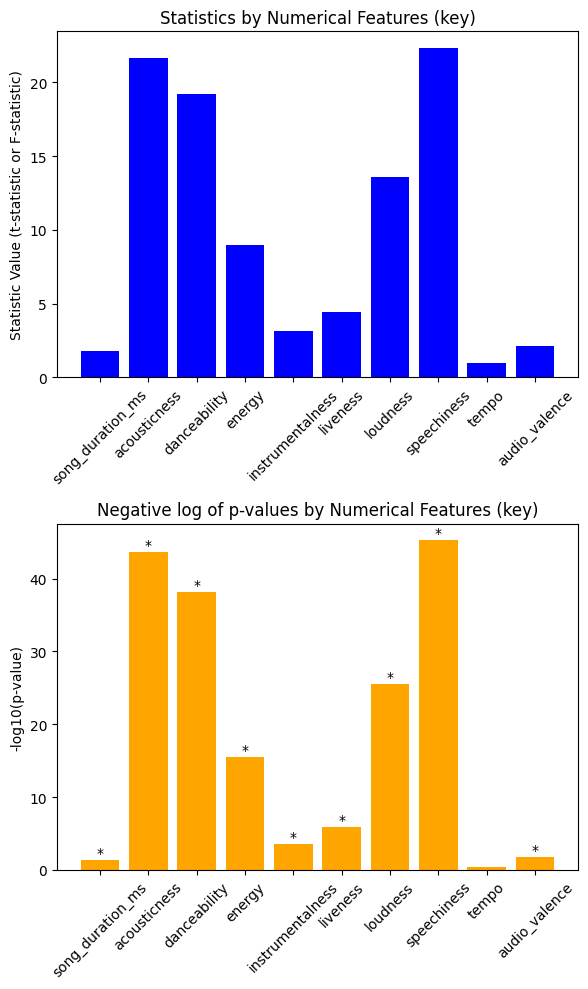

Significant numerical features for categorical feature 'audio_mode' (p < 0.05) are:
  song_duration_ms: p-value: 0.0006635239284011748, statistic: 3.4052
  acousticness: p-value: 1.0429644405521283e-13, statistic: -7.4439
  danceability: p-value: 2.649447034939559e-34, statistic: 12.2521
  energy: p-value: 9.350109441630333e-10, statistic: 6.1249
  instrumentalness: p-value: 0.023025605120346033, statistic: 2.2733
  loudness: p-value: 3.98929106842708e-12, statistic: 6.9446
  speechiness: p-value: 3.6327782728625506e-38, statistic: 12.9715
  tempo: p-value: 0.007121364529771229, statistic: -2.6916


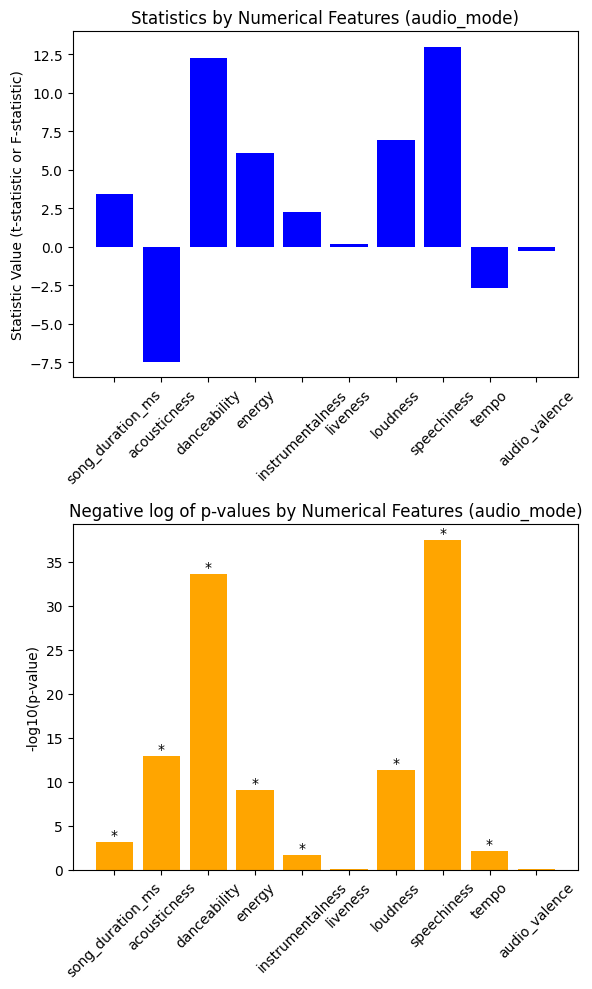

Significant numerical features for categorical feature 'time_signature' (p < 0.05) are:
  song_duration_ms: p-value: 0.006677165217707779, statistic: 3.5520
  acousticness: p-value: 9.336674438442728e-140, statistic: 166.5594
  danceability: p-value: 1.0077163415101569e-130, statistic: 155.6767
  energy: p-value: 1.4883681970992263e-139, statistic: 166.3151
  instrumentalness: p-value: 1.0627761513496167e-28, statistic: 34.4836
  liveness: p-value: 0.0005986611199853573, statistic: 4.9031
  loudness: p-value: 4.6626062323462334e-85, statistic: 101.0790
  speechiness: p-value: 1.0093077396647454e-38, statistic: 46.2927
  tempo: p-value: 5.023493852044178e-10, statistic: 12.3478
  audio_valence: p-value: 6.256654339926294e-59, statistic: 70.1265


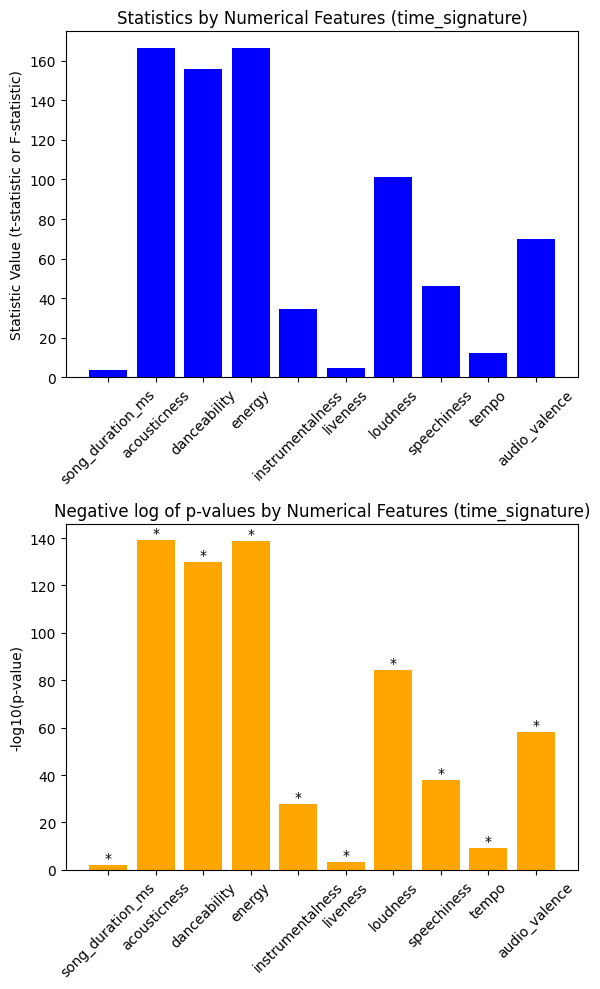

In [38]:
categorical_features = ["key", "audio_mode", "time_signature"]
numerical_features = [col for col in features_raw if col not in categorical_features]

# Perform hypothesis tests
results_df = perform_hypothesis_tests(song_data_raw, categorical_features, numerical_features)

# Plot the results
plot_hypothesis_test_results(results_df, categorical_features)